In [113]:
%matplotlib inline
import itertools
import math
import random
import numpy as np
import copy
from random import shuffle
import matplotlib
import matplotlib.pyplot as plt
import scipy


In [2]:
nr_documents = 5
relevances_cats = ['N', 'R', 'HR']
rel_values = [0.0, 1.0, 2.0]

STEP 1

In [3]:
def split_list(a_list):
    half = len(a_list)/2
    return [a_list[:half], a_list[half:]]

In [4]:
def get_combinations_list(relevances):  
    combinations = []
    for i in itertools.product(relevances, repeat = nr_documents*2):
        i = list(i)
        i = split_list(i)
        combinations.append(i)
    return combinations

In [36]:
combinations_cats = get_combinations_list(relevances_cats)
pairs = [i for i in combinations_cats]
shuffle(pairs)
pairs_sample = pairs[:2000]

STEP 2

Precision

Calculates precision at rank k with a list with 3 relevance levels (R, HR and N). 'Precision at rank k' though, asks for a binary classication problem, so HR and R is counted as relevant (1) and N as non-relevant(0).

k must be 5 or smaller

In [6]:
def precision_at(k, pairs):
    count_TP = 0 # amount of true positives
    count_FP = 0 # amount of false positives
    precision_list =[]
    for pair in pairs:
        for m in range(0, k):
            l = pair[0][m]
            if l == 'R': count_TP += 1
            elif l == 'HR': count_TP += 1
            else : count_FP+=1
            precision_P = count_TP / float(count_TP + count_FP)
        count_TP = 0
        count_FP = 0
        for m in range(0,k):
            l = pair[1][m]
            if l == 'R': count_TP += 1
            elif l == 'HR': count_TP += 1
            else : count_FP += 1
            precision_E = count_TP / float(count_TP + count_FP)
        precisions = [precision_P, precision_E]
        precision_list.append(precisions)
    return precision_list

DCG

k must be 5 or smaller

In [7]:
def dcg_at(k, pairs):
    EP_results = []
    for pair in pairs:
        rank_dcgs = []
        for ranking in pair:
            dcg = 0
            for r in range(1,k+1): # r = 1,2,3,4,5
                if ranking[r-1] == relevances_cats[0]:
                    rel_value = rel_values[0]
                elif ranking[r-1] == relevances_cats[1]:
                    rel_value = rel_values[1]
                else:
                    rel_value = rel_values[2]
                dcg += ((2**rel_value)-1)/(math.log(1+r,2))
            rank_dcgs.append(dcg)
        EP_results.append(rank_dcgs)
    return EP_results

ERR


In [8]:
def R(g): # mapping from relevance grades g to probability of relevance  
    if g == relevances_cats[0]:
        rel_value = rel_values[0]
    elif g == relevances_cats[1]:
        rel_value = rel_values[1]
    else:
        rel_value = rel_values[2]
        
    return ((2**rel_value)-1)/float((2**max(rel_values)))

In [9]:
def P(seq, r): # probability that user stops at position r
    P = 1
    for i in range(1,(r-1)+1):
        P *= (1-R(seq[i])) * R(seq[r-1])
    return P 

In [10]:
def err(pairs): # a cascade based metric with x(r) = 1/r
    ERR_results = []
    for pair in pairs:
        rank_err = []
        for ranking in pair:
            err = 0
            for r in range(1, len(ranking)+1):
                err += (1/float(r))*P(ranking, r)
            rank_err.append(err)
        ERR_results.append(rank_err)
    return ERR_results 

STEP 3

In [11]:
def calculate_differences(results):
    difference_measures=[]
    for algo in results:
        a = algo[0]
        b = algo[1]
        difference = b - a
        if (difference > 0 ): difference_measures.append(difference)
    return difference_measures

In [12]:
precision = precision_at(5, pairs_sample)
dcg = dcg_at(5, pairs_sample)
err = err(pairs_sample)

difference_measures_prec = calculate_differences(precision)
difference_measures_dcg = calculate_differences(dcg)
difference_measures_err = calculate_differences(err)

STEP 4

In [13]:
def flip_coin():
    random.seed()
    return random.getrandbits(1)

In [14]:
# generates a list with 10 random bits. 1 represents a click.

def generate_random_clicks():
    clicks = []
    for i in range(nr_documents*2):
        clicks.append(flip_coin())
    return clicks

Team-draft interleaving

In [15]:
def team_draft_interleaving(rankings):
    random.seed()
    new_ranking = []
    for i in range(nr_documents):
        winner = flip_coin()
        new_ranking.append([rankings[winner][i], winner])       
        new_ranking.append([rankings[1-winner][i], 1-winner])
       
    return new_ranking

Probabilistic interleaving

In [16]:
def init_softmaxes(rankings, tau):
    denominator = 0
    for i in range(1, (len(rankings[0])+1)):
        denominator += 1 / float(i ** tau)
    index = 1
    softmax1 = []
    softmax2 = []
    for ranking in rankings[0]:
        prob = (1/float(index**tau))/float(denominator)
        softmax1.append(prob)
        softmax2.append(prob)
        index += 1
    return softmax1, softmax2

In [17]:
def recalculate_softmax(softmax, pick):
    softmax.remove(softmax[pick])
    softmax[:] = [x/float(sum(softmax)) for x in softmax]
    return softmax

In [18]:
def probabilistic_interleaving(rankings1, tau):
    probrankings = copy.deepcopy(rankings1)
    conc_list = []
    s1, s2 = init_softmaxes(probrankings, tau)
    
    while probrankings[0] or probrankings[1]:
        
        winner = flip_coin() # keep flipping until all lists are empty
        
        if winner == 0 and probrankings[0]:
            
            pick = np.random.choice(len(probrankings[0]), 1, p=s1)
            conc_list.append([probrankings[winner][pick], winner]) # add pick to the concatenated list
            probrankings[winner].remove(probrankings[winner][pick]) # remove the pick from the document list
            s1 = recalculate_softmax(s1, pick) # recalculate the softmax of that list to normalise
                
        elif winner == 1 and probrankings[1]:
            
            pick = np.random.choice(len(probrankings[1]), 1, p=s2)
            conc_list.append([probrankings[winner][pick], winner]) # add pick to the concatenated list
            probrankings[winner].remove(probrankings[winner][pick]) # remove the pick from the document list
            s2 = recalculate_softmax(s2, pick) # recalculate the softmax of that list to normalise
                
    return conc_list

In [19]:
def get_interleaf_credits(ranking, clicks):
    credits = [0,0]
    for i in range(len(clicks)):
        if clicks[i] == 1:
            credits[ranking[i][1]] += 1
    return credits

STEP 5

In [20]:
def process_data(filename):
    data = []
    with open(filename) as f:  
        f = f.readlines()
        for line in f:
            data.append(line.split())
    return data

data = process_data("training_data.txt")

In [21]:
def rand():
    return random.random()

In [22]:
# required method (c)
def is_clicked(P):
    result = 1 if rand() < P else 0
    return result

RCM

In [23]:
# required method (b)
def predict_click_probabilities_RCM(nr_clicks, nr_docs):
    return nr_clicks / float(nr_docs)

Calculated with the assumption that people do not see the same query-page pair more than once:

In [24]:
# required method (a)
def get_parameter_RCM():
    nr_clicks = 0
    nr_doc_pages = 0
    for row in data:
        if 'C' in row:
            nr_clicks += 1
        else:
            nr_doc_pages += 1
    nr_docs = nr_doc_pages*10
    return nr_clicks, nr_docs

In [25]:
nr_clicks, nr_docs = get_parameter_RCM()
click_probability_RCM = predict_click_probabilities_RCM(nr_clicks, nr_docs)

In [26]:
print 'RCM click probability: ', click_probability_RCM

RCM click probability:  0.13445559411


In [27]:
# printing the simulated clicks
def get_clicks_RCM(documents):
    sim_clicks_RCM = []   
    
    for document in range(len(documents)):
        sim_clicks_RCM.append(is_clicked(click_probability_RCM))
    return sim_clicks_RCM

Position-based model PBM

In [28]:
def predict_click_probabilities_PBM(documents, g):
    click_probabilities = []
    
    alphas = [0] * (nr_documents*2)
    for i in range(len(documents)):
        if documents[i][0] == relevances_cats[0]:
            alphas[i] = 0.2
        if documents[i][0] == relevances_cats[1]:
            alphas[i] = 0.8
        if documents[i][0] == relevances_cats[-1]:
            alphas[i] = 0.95

    for i in range(nr_documents*2):
        P = alphas[i] * g[i]
        click_probabilities.append(P)
        
    return click_probabilities
    

In [29]:
def new_gammas(g, a, queries):
    all_query_gammas = [0] * 50 
    for values in queries.values(): #[[docid, boolean],[...,...]] 
        query_gammas = g[:] # [0.5, 0.5, ...]
        index = 0
        for doc in values: # [docid, boolean]  
            clicked = doc[1] # boolean
            gamma = clicked + ((1-clicked)*(((1-a[index])*query_gammas[index])/(1-query_gammas[index]*a[index])))
            query_gammas[index] = gamma
            index +=1   
        for i in range(len(query_gammas)):
            all_query_gammas[i] += query_gammas[i]
    
    for i in range(len(all_query_gammas)):
        all_query_gammas[i] /= len(queries)
        
    return all_query_gammas

In [30]:
def get_click_results(session):
    query_results = {}
    last_query = 0
    for row in session:
        # query action
        if 'Q' in row: 
            last_query = row[3]
            retrieved_docs = row[5:]
            for docid in range(len((retrieved_docs))):
                retrieved_docs[docid] = [retrieved_docs[docid], 0]
            if row[3] not in query_results:     
                query_results[row[3]] = retrieved_docs
            else:
                for i in range(len(retrieved_docs)):
                    exists = False
                    for document in query_results[row[3]]:
                        if retrieved_docs[i][0] in document:
                            exists = True
                            break
                    if not exists:
                        query_results[row[3]] += [retrieved_docs[i]]
                        
        # click action
        else:
            found = False
            while not found:
                # check if its in the last query (most likely the correct query page)
                for values in query_results[last_query]:
                    if row[3] == values[0]:
                        values[1] = 1
                        found = True
                        
                # otherwise, check in other query pages
                for queries in query_results.values():
                    for values in queries:
                        
                        if row[3] == values[0]:
                            values[1] = 1
                            found = True
                            
    return query_results

In [31]:
# required method (a)
def get_parameters_PBM(data_slice):
    alphas = [0.2] * 50 
    
    gammas = [0.6] * 50
    learned_gammas = [0] * 50
    
    # get examination probabilities
    sessions = set(map(lambda x:x[0], data_slice))
    sessions_data = [[y for y in data_slice if y[0]==x] for x in sessions]
    session_nr = 1
    for session in sessions_data:
        session_nr += 1
        query_results = get_click_results(session)
        session_gammas = new_gammas(gammas, alphas, query_results)
        for i in range(len(session_gammas)):
            learned_gammas[i] += session_gammas[i]
    for i in range(len(learned_gammas)):
        learned_gammas[i] /= len(sessions_data)
        learned_gammas[i] = learned_gammas[i]
    return learned_gammas[:nr_documents*2]        

In [32]:
data_slice = data[0:20000]
gammas = get_parameters_PBM(data_slice)

In [33]:
def get_clicks_PBM(documents):
    sim_clicks_PBM = []
    
    click_probabilities_PBM = predict_click_probabilities_PBM(documents, gammas)

    for document_index in range(len(documents)):
        sim_clicks_PBM.append(is_clicked(click_probabilities_PBM[document_index]))

    return sim_clicks_PBM

STEP 6 

Experiments.


This method runs N experiments with a list of categorical rankings E and P with categories (HR/R/N).
It takes one of the rankings and runs both a team_draft and probabilistic interleave with different random click values, but with the same ranking.


We should think of what it means to use different ranking combinations or the same click values for each simulation.


It prints out the E proportion for both the team-draft and the probabilistic interleave.


We should make a measure for which we can compare results between on- and offline evaluation, between the 2 interleaves and the different click models.

In [38]:
def interleaving_experiment(ranking_pairs, N):
    print 'p_messures: [team-RCM, team-PBM, prob-RCM, prob-PBM]'
    all_p_meassures = []
    nr_pair = 0
    for pair in ranking_pairs:
        total_games = [[0,0],[0,0]]
        p_meassures = [[0,0],[0,0]]
        nr_pair += 1
        

        # executing the N simulations
        for i in range(N):
            
            interleaf_rankings = [team_draft_interleaving(pair), probabilistic_interleaving(pair, 3)]
            
            interleaf_algo_nr = 0
            for ranking in interleaf_rankings:
                
                
                # generating 2 sets of clicks of the models          
                click_models = [get_clicks_RCM(ranking), get_clicks_PBM(ranking)]
                
                click_algo_nr = 0
                for clicks in click_models:
                    credits = get_interleaf_credits(ranking, clicks)
                    total_games[interleaf_algo_nr][click_algo_nr] += 1
                    if credits[0] != credits[1]: # if not a tie:
                        winner = credits.index(max(credits)) # 0 or 1: P or E
                        if winner == 1:
                            p_meassures[interleaf_algo_nr][click_algo_nr] += 1
                    click_algo_nr += 1
                interleaf_algo_nr += 1
                            
        # dividing the E-win-counts by the total nr of games to get the P meassure                        
        for i in range(len(p_meassures)): # 0 and 1
            for j in range(len(p_meassures[i])): # 
                p_meassures[i][j] /= float(total_games[i][j])
                
        
        p_meassures = reduce(lambda x, y: x + y, p_meassures, [])        
        print 'Pair: ', nr_pair, '/', len(ranking_pairs), p_meassures
        
        all_p_meassures.append(p_meassures)
        
    # printing the results
    return all_p_meassures

In [39]:
all_p_meassures = interleaving_experiment(pairs_sample, 30)

p_messures: [team-RCM, team-PBM, prob-RCM, prob-PBM]


/Users/diederusticus/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/diederusticus/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/diederusticus/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  from ipykernel import kernelapp as app
/Users/diederusticus/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/diederusticus/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error

Pair:  1 / 2000 [0.16666666666666666, 0.5666666666666667, 0.26666666666666666, 0.4666666666666667]
Pair:  2 / 2000 [0.3, 0.6333333333333333, 0.4, 0.4]
Pair:  3 / 2000 [0.36666666666666664, 0.8333333333333334, 0.3333333333333333, 0.5333333333333333]
Pair:  4 / 2000 [0.36666666666666664, 0.36666666666666664, 0.26666666666666666, 0.2]
Pair:  5 / 2000 [0.16666666666666666, 0.4666666666666667, 0.36666666666666664, 0.3]
Pair:  6 / 2000 [0.3333333333333333, 0.4666666666666667, 0.43333333333333335, 0.3]
Pair:  7 / 2000 [0.4, 0.26666666666666666, 0.3333333333333333, 0.26666666666666666]
Pair:  8 / 2000 [0.3, 0.6666666666666666, 0.3333333333333333, 0.5]
Pair:  9 / 2000 [0.3, 0.26666666666666666, 0.4, 0.13333333333333333]
Pair:  10 / 2000 [0.16666666666666666, 0.26666666666666666, 0.36666666666666664, 0.3333333333333333]
Pair:  11 / 2000 [0.23333333333333334, 0.43333333333333335, 0.4, 0.3]
Pair:  12 / 2000 [0.26666666666666666, 0.6333333333333333, 0.3333333333333333, 0.8]
Pair:  13 / 2000 [0.4333

STEP 7 PBM better because it takes into account the attractiveness and that is based on the true relevance labels

In this section we compare the results of the offline experiments (delta meassures) with the results of the online experiment (i.e. proportion of wins). We analyze them and reach our conclusions regarding their agreement.

Offline Experiments

For the offline experiments we used the three meassurements: (1) Precision, (2) Discounted Cumulative Gain and (3) Expected Reciprocal Rank. 



In [79]:
meassures_per_model = [0,0,0,0]
for i in range(len(all_p_meassures)):
    for j in range(len(all_p_meassures[i])):
        meassures_per_model[j] += all_p_meassures[i][j]
        
for i in range(len(meassures_per_model)):
    meassures_per_model[i] /= len(all_p_meassures)

[0.305283333333332, 0.3658000000000011, 0.3047666666666659, 0.3670499999999992]


Proportions of wins of E:

Team-draft IL & PBM:  0.366
Probabilistic IL & PBM:  0.367
Team-draft IL & RCM:  0.305
Probabilistic IL & RCM:  0.305


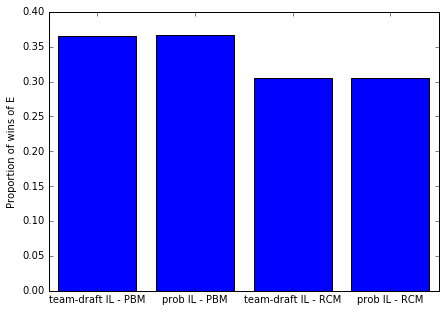

In [140]:
dictionary = plt.figure(num=None, figsize=(7, 5), dpi=80, facecolor='w', edgecolor='k')

D = {u'team-draft IL - RCM':meassures_per_model[0], u'team-draft IL - PBM': meassures_per_model[1], u'prob IL - RCM':meassures_per_model[2], u'prob IL - PBM':meassures_per_model[3]}

plt.bar(range(len(D)), D.values(), align='center')
plt.ylabel("Proportion of wins of E")
plt.xticks(range(len(D)), D.keys())
print 'Proportions of wins of E:\n'

print 'Team-draft IL & PBM: ', round(meassures_per_model[1],3)
print 'Probabilistic IL & PBM: ', round(meassures_per_model[3],3)
print 'Team-draft IL & RCM: ', round(meassures_per_model[0],3)
print 'Probabilistic IL & RCM: ', round(meassures_per_model[2],3)

In [138]:
all_d_meassures = [difference_measures_prec, difference_measures_dcg, difference_measures_err]

# plots: [[teamRcm:[prec],[dcg],[err]],[teamPBM:[prec],[dcg],[err]],[probRcm:[prec],[dcg],[err]],[probRcm:[prec],[dcg],[err]],
plots = [[[[],[]],[[],[]],[[],[]]],[[[],[]],[[],[]],[[],[]]],[[[],[]],[[],[]],[[],[]]],[[[],[]],[[],[]],[[],[]]]]
for online_combo in range(len(all_p_meassures[0])):
    
        for offline_algo in range(len(all_d_meassures)):
            for i in range(len(all_p_meassures)): 
                x = all_p_meassures[i][online_combo]
                y = all_d_meassures[offline_algo][i]
                plots[online_combo][offline_algo][0].append(x)
                plots[online_combo][offline_algo][1].append(y)

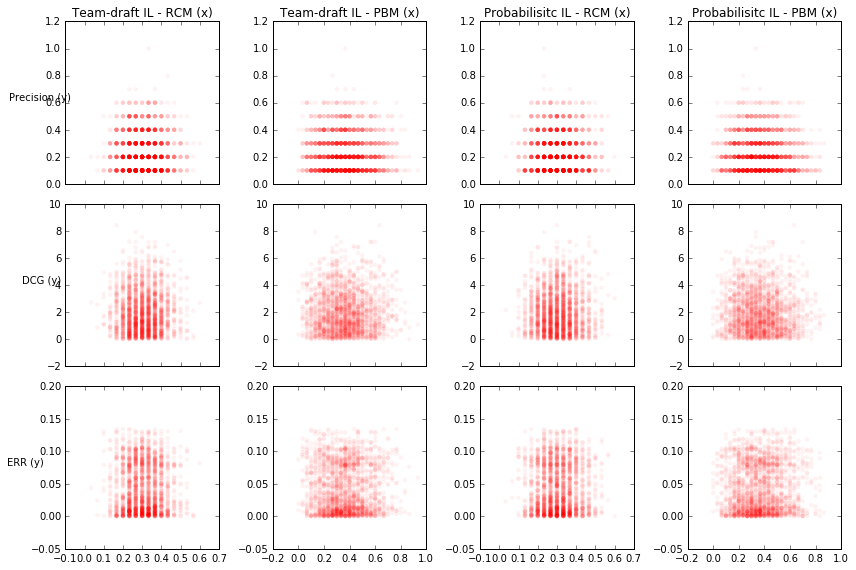

In [139]:
f, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12)) = plt.subplots(3,4,sharex='col',figsize=(12, 8))

# first 4 plots (precisions)
ax1.scatter(plots[0][0][0], plots[0][0][1], edgecolors='none',alpha=0.05,c='red')
ax1.set_title("Team-draft IL - RCM (x)")
ax1.set_ylabel("Precision (y)", rotation=0)
ax2.scatter(plots[1][0][0], plots[1][0][1], edgecolors='none',alpha=0.05,c='red')
ax2.set_title("Team-draft IL - PBM (x)")
ax3.scatter(plots[2][0][0], plots[2][0][1], edgecolors='none',alpha=0.05,c='red')
ax3.set_title("Probabilisitc IL - RCM (x)")
ax4.scatter(plots[3][0][0], plots[3][0][1], edgecolors='none',alpha=0.05,c='red')
ax4.set_title("Probabilisitc IL - PBM (x)")

# second 4 plots (DCGs)
ax5.scatter(plots[0][1][0], plots[0][1][1], edgecolors='none',alpha=0.05,c='red')
ax5.set_ylabel("DCG (y)", rotation=0)
ax6.scatter(plots[1][1][0], plots[1][1][1], edgecolors='none',alpha=0.05,c='red')
ax7.scatter(plots[2][1][0], plots[2][1][1], edgecolors='none',alpha=0.05,c='red')
ax8.scatter(plots[3][1][0], plots[3][1][1], edgecolors='none',alpha=0.05,c='red')

# last 4 plots (ERRs)
ax9.scatter(plots[0][2][0], plots[0][2][1], edgecolors='none',alpha=0.05,c='red')
ax9.set_ylabel("ERR (y)", rotation=0)
ax10.scatter(plots[1][2][0], plots[1][2][1], edgecolors='none',alpha=0.05,c='red')
ax11.scatter(plots[2][2][0], plots[2][2][1], edgecolors='none',alpha=0.05,c='red')
ax12.scatter(plots[3][2][0], plots[3][2][1], edgecolors='none',alpha=0.05,c='red')


plt.tight_layout()